1) Se cargan las librerias necesarias

In [244]:
# Manipulación de datos y operaciones básicas
import numpy as np
import pandas as pd

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento de datos
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Modelos de Machine Learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Selección y validación de modelos
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV

# Métricas de evaluación
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Técnicas de balanceo de clases
from imblearn.over_sampling import  SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


2) Se carga la base de datos

In [245]:
medical_appointments = pd.read_csv('Attendance of Medical Appointments in Brazil (may2016).csv')

3. Visualizacion de datos

In [246]:
# Numero de filas y columnas
medical_appointments.shape

(110527, 14)

In [247]:
# Encabezados
medical_appointments.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [248]:
# Tipo de datos
data_types = medical_appointments.dtypes
print(data_types)


PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object


In [249]:
# Numero de valores unicos por columna
column_counts = medical_appointments.nunique()
print(column_counts)

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64


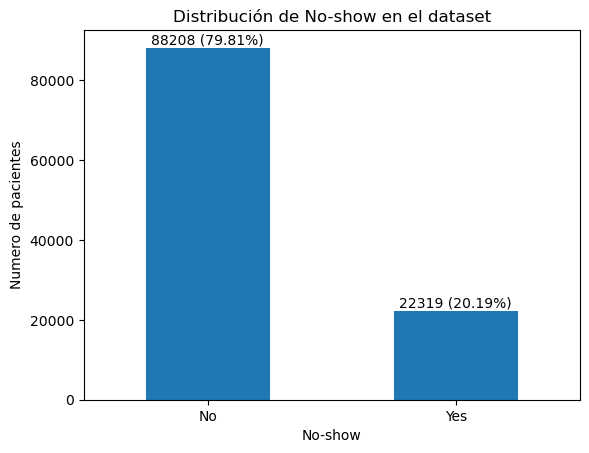

In [250]:
# Distribución del dataset
class_counts = medical_appointments['No-show'].value_counts()
class_counts.plot(kind='bar', rot=0)
plt.xlabel('No-show')
plt.ylabel('Numero de pacientes')
plt.title('Distribución de No-show en el dataset')
for i, count in enumerate(class_counts):
    plt.text(i, count, f'{count} ({count / len(medical_appointments) * 100:.2f}%)', ha='center', va='bottom')
plt.show()

In [251]:
# Evaluar presencia de Missing values
missing_values = medical_appointments.isnull().sum()
print(missing_values)

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64


4. Feature Engeniering

In [252]:
# Crear una copia del dataset original
medical_appointments_transformed = medical_appointments.copy()

# Transformar las fechas a formato datetime
medical_appointments_transformed['ScheduledDay'] = pd.to_datetime(medical_appointments_transformed['ScheduledDay'])
medical_appointments_transformed['AppointmentDay'] = pd.to_datetime(medical_appointments_transformed['AppointmentDay'])

# Calcular el tiempo antes de la cita
medical_appointments_transformed['Time_Before_Appointment'] = (medical_appointments_transformed['AppointmentDay'] - medical_appointments_transformed['ScheduledDay']).dt.total_seconds()

# Se agrega el día de la semana de la cita
medical_appointments_transformed['Appointment_DayOfWeek'] = medical_appointments_transformed['AppointmentDay'].dt.day_name()

# Se convierte de time a int
medical_appointments_transformed['ScheduledDay'] = medical_appointments_transformed['ScheduledDay'].dt.strftime('%Y%m%d').astype(int)
medical_appointments_transformed['AppointmentDay'] = medical_appointments_transformed['AppointmentDay'].dt.strftime('%Y%m%d').astype(int)

# Instanciar un nuevo LabelEncoder para cada columna categórica
gender_encoder = LabelEncoder()
neighbourhood_encoder = LabelEncoder()
no_show_encoder = LabelEncoder()
Appointment_DayOfWeek_encoder = LabelEncoder()

# Convertir las columnas categóricas a numéricas usando fit_transform
medical_appointments_transformed['Gender'] = gender_encoder.fit_transform(medical_appointments_transformed['Gender'])
medical_appointments_transformed['Neighbourhood'] = neighbourhood_encoder.fit_transform(medical_appointments_transformed['Neighbourhood'])
medical_appointments_transformed['No-show'] = no_show_encoder.fit_transform(medical_appointments_transformed['No-show'])
medical_appointments_transformed['Appointment_DayOfWeek'] = Appointment_DayOfWeek_encoder.fit_transform(medical_appointments_transformed['Appointment_DayOfWeek'])

# Visualizar los cambios
medical_appointments_transformed.head()



,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Time_Before_Appointment,Appointment_DayOfWeek
0,2.987250e+13,5642903,0,20160429,20160429,62,39,0,1,0,0,0,0,0,-67088.0,0
1,5.589978e+14,5642503,1,20160429,20160429,56,39,0,0,0,0,0,0,0,-58107.0,0
2,4.262962e+12,5642549,0,20160429,20160429,62,45,0,0,0,0,0,0,0,-58744.0,0
3,8.679512e+11,5642828,0,20160429,20160429,8,54,0,0,0,0,0,0,0,-62971.0,0
4,8.841186e+12,5642494,0,20160429,20160429,56,39,0,1,1,0,0,0,0,-58043.0,0


In [253]:
#Verificar tipo de datos
data_types = medical_appointments_transformed.dtypes
print(data_types)

PatientId                  float64
AppointmentID                int64
Gender                       int64
ScheduledDay                 int64
AppointmentDay               int64
Age                          int64
Neighbourhood                int64
Scholarship                  int64
Hipertension                 int64
Diabetes                     int64
Alcoholism                   int64
Handcap                      int64
SMS_received                 int64
No-show                      int64
Time_Before_Appointment    float64
Appointment_DayOfWeek        int64
dtype: object


5. Entrneammiento de DecisionTreeClassifier

Accuracy: 0.7066870538420477
Precision: 0.28378146942969684
Recall: 0.2969667099780456


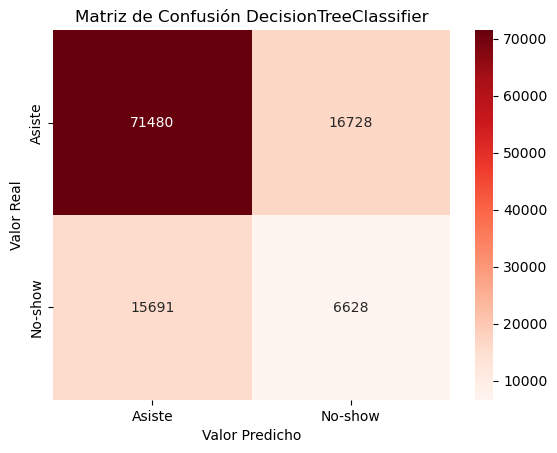

In [254]:
# Se define la variable objetivo y las variables predictoras
X = medical_appointments_transformed.drop('No-show', axis=1)
y = medical_appointments_transformed['No-show']

# Crear una instancia de DecisionTreeClassifier
clf_tree = DecisionTreeClassifier()

# Se realiza la validación cruzada para obtener predicciones para todo el conjunto de datos
y_pred = cross_val_predict(clf_tree, X, y, cv=5)

# Se crea una matriz de confusión
confusion_mat = confusion_matrix(y, y_pred)
labels = ['Asiste', 'No-show']
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)

# Configuración del gráfico
plt.title('Matriz de Confusión DecisionTreeClassifier')
plt.xlabel('Valor Predicho')
plt.ylabel('Valor Real')

# Se calculan las métricas de evaluación
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred, pos_label=1)
recall = recall_score(y, y_pred, pos_label=1)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
plt.show()

6. Balanceo de clases

Text(0.5, 1.0, 'Distribución de No-show en el dataset')

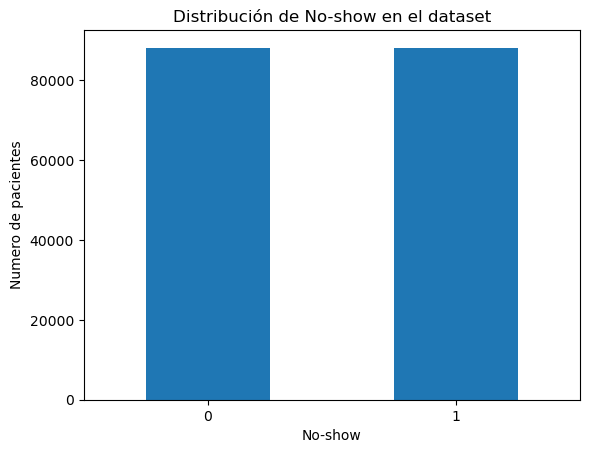

In [255]:
# Se crea una instancia de SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Se aplica SMOTE a los datos
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Se crea una instancia de la clase Pipeline
pipeline = Pipeline([('smote', smote), ('rus', rus)])

# Se aplica el pipeline a los datos
X_balanced, y_balanced = pipeline.fit_resample(X, y)

# Se grafica la distribución de las clases
class_counts = y_balanced.value_counts()
class_counts.plot(kind='bar', rot=0)
plt.xlabel('No-show')
plt.ylabel('Numero de pacientes')
plt.title('Distribución de No-show en el dataset')

7.  Estandarización de datos

   PatientId  AppointmentID    Gender  ScheduledDay  AppointmentDay       Age  \
0  -0.458827      -0.348046 -0.615318       -0.2248       -2.594489  1.213158   
1   1.611672      -0.353868  1.625176       -0.2248       -2.594489  0.934423   
2  -0.559039      -0.353198 -0.615318       -0.2248       -2.594489  1.213158   
3  -0.572324      -0.349138 -0.615318       -0.2248       -2.594489 -1.295458   
4  -0.541124      -0.353999 -0.615318       -0.2248       -2.594489  0.934423   

   Neighbourhood  Scholarship  Hipertension  Diabetes  Alcoholism  Handcap  \
0      -0.117510    -0.281369      2.463436 -0.227895   -0.145777 -0.11798   
1      -0.117510    -0.281369     -0.405937 -0.227895   -0.145777 -0.11798   
2       0.166318    -0.281369     -0.405937 -0.227895   -0.145777 -0.11798   
3       0.592059    -0.281369     -0.405937 -0.227895   -0.145777 -0.11798   
4      -0.117510    -0.281369      2.463436  4.387986   -0.145777 -0.11798   

   SMS_received  Time_Before_Appointment  Ap

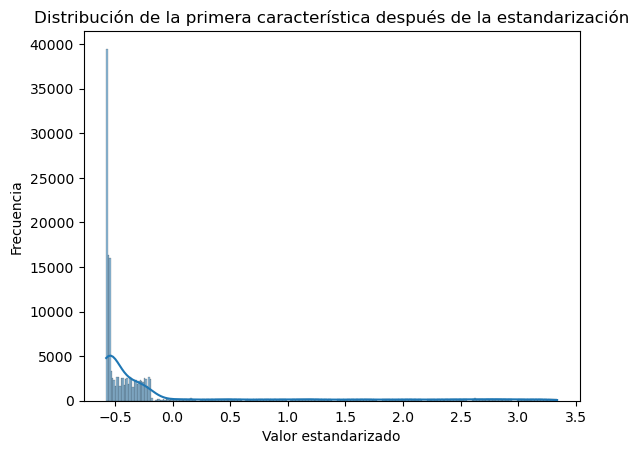

In [256]:
# Se crea una instancia de StandardScaler
scaler = StandardScaler()

# Se ajusta el escalador a los datos balanceados y se transforman
X_balanced_scaled = scaler.fit_transform(X_balanced)

# Convertir el resultado a DataFrame para facilitar la manipulación y visualización
X_balanced_scaled_df = pd.DataFrame(X_balanced_scaled, columns=X.columns)

# Mostrar los primeros encabezados del conjunto de datos estandarizado
print(X_balanced_scaled_df.head())

# Si deseas visualizar la distribución de alguna característica después de la estandarización, puedes hacerlo con un gráfico
import seaborn as sns

# Ejemplo de visualización de la distribución de la primera característica
sns.histplot(X_balanced_scaled_df.iloc[:, 0], kde=True)
plt.title('Distribución de la primera característica después de la estandarización')
plt.xlabel('Valor estandarizado')
plt.ylabel('Frecuencia')
plt.show()


8. Modelos de Machine Learning:

8.1 Entrenamiento Regresión Logisitica (datos balanceados y estandarizados)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros encontrados: {'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Mejor modelo: LogisticRegression(C=0.01, max_iter=1000)
Accuracy (Datos Balanceados): 0.5912672319970977
Precision (Datos Balanceados): 0.5757544391226205
Recall (Datos Balanceados): 0.693655904226374


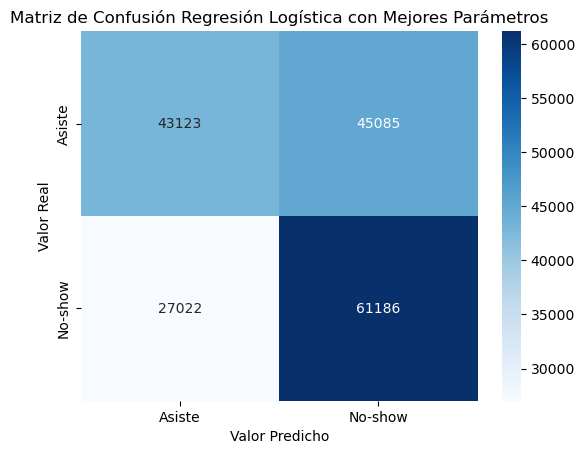

In [257]:
# Crear una instancia de LogisticRegression
clf_logistic = LogisticRegression()

# Diccionario de parametros a probar
param_grid = {
    'max_iter': [1000, 2000], # Numero de iteraciones
    'penalty': ['l2'], # Tipos de penalización
    'C': [0.01, 0.1, 1, 10, 100], # Valores de regularización
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'] # Algoritmos para la optimización
}

# Crear una instancia de GridSearchCV optimizada para la precisión
grid_search = GridSearchCV(clf_logistic, param_grid, cv=5, scoring='precision', verbose=1, n_jobs=-1)

# Ajustar GridSearchCV
grid_search.fit(X_balanced_scaled, y_balanced)

# Ver los mejores parámetros y el mejor modelo
print('Mejores parámetros encontrados:', grid_search.best_params_)
print('Mejor modelo:', grid_search.best_estimator_)

# Realizar la validación cruzada para obtener predicciones para todo el conjunto de datos balanceados usando el mejor modelo
y_pred_balanced_logistic = cross_val_predict(grid_search.best_estimator_, X_balanced_scaled, y_balanced, cv=5)

# Se crea una matriz de confusión
confusion_mat_balanced_logistic = confusion_matrix(y_balanced, y_pred_balanced_logistic)
labels = ['Asiste', 'No-show']
sns.heatmap(confusion_mat_balanced_logistic, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Configuración del gráfico
plt.title('Matriz de Confusión Regresión Logística (Mejores Parámetros)')
plt.xlabel('Valor Predicho')
plt.ylabel('Valor Real')

# Se calculan las métricas de evaluación
accuracy_balanced_logistic = accuracy_score(y_balanced, y_pred_balanced_logistic)
precision_balanced_logistic = precision_score(y_balanced, y_pred_balanced_logistic, pos_label=1) 
recall_balanced_logistic = recall_score(y_balanced, y_pred_balanced_logistic, pos_label=1)

print("Accuracy (Datos Balanceados):", accuracy_balanced_logistic)
print("Precision (Datos Balanceados):", precision_balanced_logistic)
print("Recall (Datos Balanceados):", recall_balanced_logistic)
plt.show()


8.2 Entrenamiento de DecisionTreeClassifier (Datos balanceados)

Mejores parámetros: {'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 5}
Mejor puntaje de accuracy: 0.7189333624909076


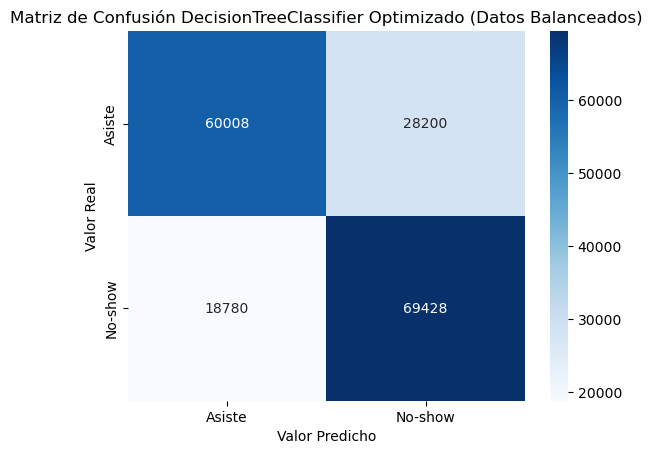

Accuracy (Datos Balanceados): 0.733697623798295
Precision (Datos Balanceados): 0.7111484410210186
Recall (Datos Balanceados): 0.7870941411209867


In [258]:
# Definir el espacio de parámetros para GridSearchCV
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50], # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10], # Número mínimo de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4], # Número mínimo de muestras requeridas en cada nodo hoja
    'criterion': ['gini', 'entropy'] # Función para medir la calidad de una división
}

# Crear una instancia de GridSearchCV, optimizada para la precisión
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='precision', n_jobs=-1)

# Ajustar GridSearchCV a los datos
grid_search.fit(X_balanced, y_balanced)

# Imprimir los mejores parámetros y el mejor puntaje
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntaje de accuracy:", grid_search.best_score_)

# Usar el mejor modelo para realizar predicciones
best_tree = grid_search.best_estimator_
y_pred_balanced = cross_val_predict(best_tree, X_balanced, y_balanced, cv=5)

# Crear y visualizar la matriz de confusión
confusion_mat_balanced = confusion_matrix(y_balanced, y_pred_balanced)
labels = ['Asiste', 'No-show']
sns.heatmap(confusion_mat_balanced, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusión DecisionTreeClassifier (Mejores parametros y datos Balanceados)')
plt.xlabel('Valor Predicho')
plt.ylabel('Valor Real')
plt.show()

# Calcular y mostrar las métricas de evaluación
accuracy_balanced = accuracy_score(y_balanced, y_pred_balanced)
precision_balanced = precision_score(y_balanced, y_pred_balanced, pos_label=1)
recall_balanced = recall_score(y_balanced, y_pred_balanced, pos_label=1)

print("Accuracy (Datos Balanceados):", accuracy_balanced)
print("Precision (Datos Balanceados):", precision_balanced)
print("Recall (Datos Balanceados):", recall_balanced)


9. Modelos ensamblados

9.1 Entrneamiento de random forest Classifier

Accuracy (Datos Balanceados): 0.7516041628877199
Precision (Datos Balanceados): 0.7231152798303023
Recall (Datos Balanceados): 0.8154475784509342


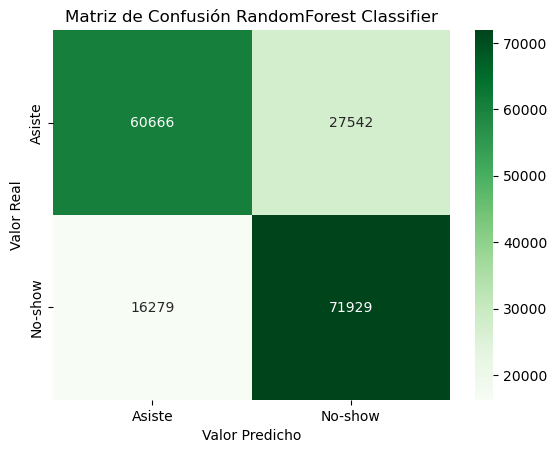

[[60666 27542]
 [16279 71929]]


In [259]:
# Crear una instancia de RandomForestClassifier con parámetros predeterminados
rf_balanced = RandomForestClassifier(
    n_estimators=100,     # Numero de arboles
    max_depth=20,         # Profundidad del arbol, evita el sobreajuste
    min_samples_split=5,  # Aumentar este valor puede ayudar a evitar que el modelo se sobreajuste a los datos de entrenamiento.
    min_samples_leaf=2,   # Un valor más alto ayuda a suavizar el modelo, especialmente en problemas de clasificación.
    max_features='sqrt',  # Reducir el número de características consideradas para las divisiones puede hacer que el modelo sea más robusto.
    random_state=42,      # Fijar una semilla para reproducibilidad.
    class_weight='balanced'  # Clasees balanceadas
)

# Realizar la validación cruzada para obtener predicciones para todo el conjunto de datos
y_pred_balanced = cross_val_predict(rf_balanced, X_balanced, y_balanced, cv=5, method='predict')

# Se crea una matriz de confusión
confusion_mat_balanced = confusion_matrix(y_balanced, y_pred_balanced)
labels = ['Asiste', 'No-show']
sns.heatmap(confusion_mat_balanced, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)

# Configuración del gráfico
plt.title('Matriz de Confusión RandomForest Classifier (Datos Balanceados)')
plt.xlabel('Valor Predicho')
plt.ylabel('Valor Real')

# Se calculan las métricas de evaluación
accuracy_balanced = accuracy_score(y_balanced, y_pred_balanced)
precision_balanced = precision_score(y_balanced, y_pred_balanced)
recall_balanced = recall_score(y_balanced, y_pred_balanced)

print("Accuracy (Datos Balanceados):", accuracy_balanced)
print("Precision (Datos Balanceados):", precision_balanced)
print("Recall (Datos Balanceados):", recall_balanced)
plt.show()
print(confusion_mat_balanced)

9.2 Stacking: Regresión logistica + Decision Tree Classifier

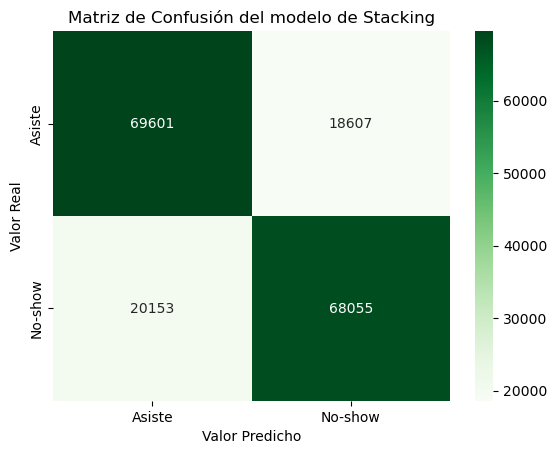

Accuracy del meta-modelo: 0.7802920370034464
Precision del meta-modelo: 0.7852922849691907
Recall del meta-modelo: 0.7715286595320152


In [260]:
# Definir los modelos base con los parámetros optimizados
clf_tree_balanced = DecisionTreeClassifier(
    criterion='entropy',  
    max_depth=10,  
    min_samples_split=2,
    min_samples_leaf=4
)
clf_logistic = LogisticRegression(
    max_iter=1000,
    penalty='l2', 
    C=1,  
    solver='lbfgs' 
)

# Configurar el k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Se preparan las matrices para almacenar las predicciones de los modelos base
y_pred_tree = np.zeros((X_balanced_scaled.shape[0], 2))  
y_pred_logistic = np.zeros((X_balanced_scaled.shape[0], 2))  

# Generar predicciones de validación cruzada para los modelos base
for train_index, test_index in kf.split(X_balanced_scaled):
    X_train_kf, X_test_kf = X_balanced_scaled[train_index], X_balanced_scaled[test_index]
    y_train_kf, y_test_kf = y_balanced[train_index], y_balanced[test_index]

    # Entrenar los modelos base en el fold actual
    clf_tree_balanced.fit(X_train_kf, y_train_kf)
    clf_logistic.fit(X_train_kf, y_train_kf)

    # Almacenar las predicciones en las matrices
    y_pred_tree[test_index] = clf_tree_balanced.predict_proba(X_test_kf)
    y_pred_logistic[test_index] = clf_logistic.predict_proba(X_test_kf)

# Usar las predicciones como características para el meta-modelo
X_meta_train = np.hstack((y_pred_tree, y_pred_logistic))

# Crear y entrenar el meta-modelo
meta_model = LogisticRegression()
meta_model.fit(X_meta_train, y_balanced)

# Obtener las etiquetas de clase predichas para la matriz de confusión y las métricas
y_pred_meta = cross_val_predict(meta_model, X_meta_train, y_balanced, cv=5, method='predict')

# Crear la matriz de confusión y calcular las métricas
confusion_mat_meta = confusion_matrix(y_balanced, y_pred_meta)
accuracy_meta = accuracy_score(y_balanced, y_pred_meta)
precision_meta = precision_score(y_balanced, y_pred_meta, pos_label=1)
recall_meta = recall_score(y_balanced, y_pred_meta, pos_label=1)

# Visualizar la matriz de confusión
labels = ['Asiste', 'No-show']
sns.heatmap(confusion_mat_meta, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusión del modelo de Stacking')
plt.xlabel('Valor Predicho')
plt.ylabel('Valor Real')
plt.show()

# Imprimir las métricas de evaluación
print("Accuracy del meta-modelo:", accuracy_meta)
print("Precision del meta-modelo:", precision_meta)
print("Recall del meta-modelo:", recall_meta)


10. Feature Selection

In [261]:
# Eliminar las columnas 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap'
# Datos que no se obtienen en el momento de la cita
X_balanced_scaled_drop = X_balanced_scaled_df.drop(['Hipertension', 'Diabetes', 'Alcoholism', 'Handcap','Scholarship'], axis=1)

# Mostrar los primeros encabezados del nuevo conjunto de datos
X_balanced_scaled_drop.head()


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,SMS_received,Time_Before_Appointment,Appointment_DayOfWeek
0,-0.458827,-0.348046,-0.615318,-0.2248,-2.594489,1.213158,-0.117510,-0.6153,-0.838697,-1.474598
1,1.611672,-0.353868,1.625176,-0.2248,-2.594489,0.934423,-0.117510,-0.6153,-0.831748,-1.474598
2,-0.559039,-0.353198,-0.615318,-0.2248,-2.594489,1.213158,0.166318,-0.6153,-0.832241,-1.474598
3,-0.572324,-0.349138,-0.615318,-0.2248,-2.594489,-1.295458,0.592059,-0.6153,-0.835512,-1.474598
4,-0.541124,-0.353999,-0.615318,-0.2248,-2.594489,0.934423,-0.117510,-0.6153,-0.831699,-1.474598


11. Se entrena nuevamente el modelo ensamblado pero con datos no clinicos

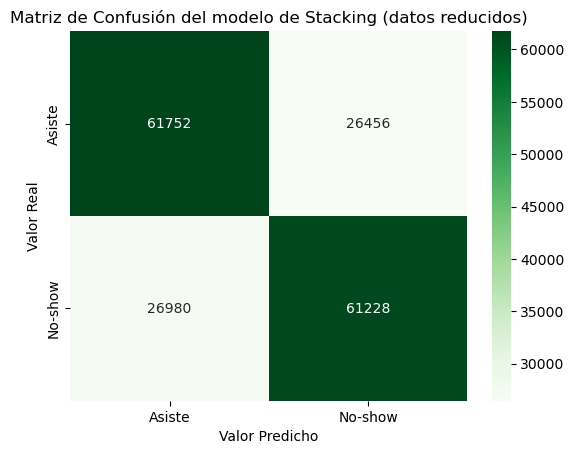

Accuracy del meta-modelo: 0.6971023036459278
Precision del meta-modelo: 0.6982801879476301
Recall del meta-modelo: 0.6941320515146019


In [266]:
# Definir los modelos base con los parámetros optimizados
clf_tree_balanced = DecisionTreeClassifier(
    criterion='entropy',  
    max_depth=10,  
    min_samples_split=2,
    min_samples_leaf=4
)
clf_logistic = LogisticRegression(
    max_iter=1000,
    penalty='l2', 
    C=1,  
    solver='lbfgs' 
)

# Configurar el k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Se preparan las matrices para almacenar las predicciones de los modelos base
y_pred_tree = np.zeros((X_balanced_scaled_drop.shape[0], 2))  
y_pred_logistic = np.zeros((X_balanced_scaled_drop.shape[0], 2))  

# Generar predicciones de validación cruzada para los modelos base
for train_index, test_index in kf.split(X_balanced_scaled_drop):
    X_train_kf, X_test_kf = X_balanced_scaled_drop.iloc[train_index], X_balanced_scaled_drop.iloc[test_index]
    y_train_kf, y_test_kf = y_balanced[train_index], y_balanced[test_index]

    # Entrenar los modelos base en el fold actual
    clf_tree_balanced.fit(X_train_kf, y_train_kf)
    clf_logistic.fit(X_train_kf, y_train_kf)

    # Almacenar las predicciones en las matrices
    y_pred_tree[test_index] = clf_tree_balanced.predict_proba(X_test_kf)
    y_pred_logistic[test_index] = clf_logistic.predict_proba(X_test_kf)

# Usar las predicciones como características para el meta-modelo
X_meta_train = np.hstack((y_pred_tree, y_pred_logistic))

# Crear y entrenar el meta-modelo
meta_model = LogisticRegression()
meta_model.fit(X_meta_train, y_balanced)

# Obtener las etiquetas de clase predichas para la matriz de confusión y las métricas
y_pred_meta = cross_val_predict(meta_model, X_meta_train, y_balanced, cv=5, method='predict')

# Generar predicciones de probabilidad con el meta-modelo para evaluar
y_predict_proba = cross_val_predict(meta_model, X_meta_train, y_balanced, cv=5, method='predict_proba')

# Crear la matriz de confusión y calcular las métricas
confusion_mat_meta = confusion_matrix(y_balanced, y_pred_meta)
accuracy_meta = accuracy_score(y_balanced, y_pred_meta)
precision_meta = precision_score(y_balanced, y_pred_meta, pos_label=1)
recall_meta = recall_score(y_balanced, y_pred_meta, pos_label=1)

# Visualizar la matriz de confusión
labels = ['Asiste', 'No-show']
sns.heatmap(confusion_mat_meta, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusión del modelo de Stacking (datos reducidos)')
plt.xlabel('Valor Predicho')
plt.ylabel('Valor Real')
plt.show()

# Imprimir las métricas de evaluación
print("Accuracy del meta-modelo:", accuracy_meta)
print("Precision del meta-modelo:", precision_meta)
print("Recall del meta-modelo:", recall_meta)


12. Se genera listado de probabilidad por usuario

In [264]:
# Generar IDs secuenciales a partir del modelo de stacking con datos no clinicos
user_ids_sequential = range(1, len(y_predict_proba) + 1)

# Seleccionar la columna de la probabilidad de interés (segunda columna para la clase positiva)
probabilidad_inasistencia = y_predict_proba[:, 1] 

# Crear el DataFrame usando la probabilidad seleccionada
usuarios_prob_df = pd.DataFrame({
    'UserID': user_ids_sequential,
    'Probabilidad_Inasistencia': probabilidad_inasistencia
})

# Exportar a un archivo CSV
usuarios_prob_df.to_csv('listado_probabilidad_inasistencia.csv', index=False)
listado_probabilidad_inasistencia= pd.read_csv('listado_probabilidad_inasistencia.csv')
print(listado_probabilidad_inasistencia.head())

   UserID  Probabilidad_Inasistencia
0       1                   0.090198
1       2                   0.109408
2       3                   0.092565
3       4                   0.202270
4       5                   0.090760
